<a href="https://colab.research.google.com/github/Edwin-Cheng/resistor_network_DNN/blob/main/active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import pandas as pd
import scipy as sp
import IPython
import sklearn
import queue

In [ ]:
Zdef get_dist(xs, ys, N, L_i, periodic = True):
    #expand x, y
    xx = np.tile(xs, (N, 1))
    yy = np.tile(ys, (N, 1))
    #periodic

    if periodic:
        xs = np.mod(xs, L_i)
        ys = np.mod(ys, L_i)
    #update direction
    if periodic:
        dx = np.abs(xx-xx.T)
        dx = np.where(dx < L_i/2, dx, L_i-dx)
        dy = np.abs(yy-yy.T)
        dy = np.where(dy < L_i/2, dy, L_i-dy)
        D = np.sqrt(dx**2+dy**2)
    else:
        D = np.sqrt((xx-xx.T)**2+(yy-yy.T)**2) #distance between nodes

    return D

def get_adj(D, R, a):
    W = 1/(1+D) #weight between nodes
    #Cut off out of range
    if R != -1: #R=-1 for infinite range
        W = np.where(W > 1/(1+R), W, 0)
    W = np.where(W != 0, W**a, 0)

    return W

In [ ]:
dt=1
def Vicsek_weight(T, N, a=0, f=1/dt, R=-1, D_i=0.1, s=0.1, noise=0.3, t_s=100, var=0.05):
    L_i = np.sqrt(N/D_i)
    ns = np.arange(N)
    xs = np.random.rand(N)*L_i
    ys = np.random.rand(N)*L_i
    dirs = (np.random.rand(N)-0.5)*2*np.pi

    xt = np.zeros((T,N))
    yt = np.zeros((T,N))
    dirt = np.zeros((T,N))
    phit = np.zeros(T)
    D_avg = np.zeros((N,N))
    Ds = queue.Queue()
    phi_max=0
    for t in range(T):
        xt[t] = xs
        yt[t] = ys
        dirt[t] = dirs

        #Weight
        D = get_dist(xs, ys, N, L_i)
        W = get_adj(D, R, a)

        Dir = np.tile(dirs, (N, 1))
        wdir = np.sum(W*Dir, axis=1)/np.sum(W, axis=1)
        #update v
        #v = v_i+at
        vx = s*np.cos(dirs)
        vy = s*np.sin(dirs)
        #look at other nodes
        Vx = np.tile(vx, (N, 1))
        wvx = np.sum(W*Vx, axis=1)/np.sum(W, axis=1)
        Vy = np.tile(vy, (N, 1))
        wvy = np.sum(W*Vy, axis=1)/np.sum(W, axis=1)
        #combine vx, vy
        dirs = dirs+dt*(f*(np.arctan2(wvy,wvx)-dirs) + noise*2*np.pi*(np.random.rand(N)-0.5))
        phi = np.sqrt(np.sum(vx)**2+np.sum(vy)**2)/N/s
        #update x, y
        xs = xs+s*np.cos(dirs)*dt
        ys = ys+s*np.sin(dirs)*dt

        phit[t] = phi
        if t>t_s:
            phi_rec = phit[t-t_s:t+1]
            #if Ds.qsize() >= 10: Ds.get()
            #Ds.put(D)
            if (np.max(phi_rec)-np.min(phi_rec)) < var: break
    #while not Ds.empty():
        #D_avg += Ds.get()
    D_avg = D

    return xt[:t+1], yt[:t+1], dirt[:t+1], phit[:t+1], D_avg, t+1

In [ ]:
def Vicsek_1d(T, N, a=0, f=1/dt, R=-1, D_i=0.1, s=1, noise=0.3, t_s=100):
    L_i = N/D_i
    ns = np.arange(N)
    xs = np.random.rand(N)*L_i
    dirs = (np.random.rand(N)-0.5)*2*np.pi

    xt = np.zeros((T,N))
    dirt = np.zeros((T,N))
    phit = np.zeros(T)
    D_avg = np.zeros((N,N))

    phi_max=0
    for t in range(T):
        xt[t] = xs
        dirt[t] = dirs
        #expand x, y
        xx = np.tile(xs, (N, 1))
        #update x, y
        xs = xs+s*np.cos(dirs)*dt
        #periodic
        periodic = True
        if periodic:
            xs = np.mod(xs, L_i)
        #update direction
        if periodic:
            dx = np.abs(xx-xx.T)
            dx = np.where(dx < L_i/2, dx, L_i-dx)
            D = dx
        else:
            D = np.abs(xx-xx.T) #distance between nodes
        W = 1/(1+D) #weight between nodes
        #Cut off out of range
        if R != -1: #R=-1 for infinite range
            W = np.where(W > 1/(1+R), W, 0)
        W = np.where(W != 0, W**a, 0)
        Dir = np.tile(dirs, (N, 1))
        wdir = np.sum(W*Dir, axis=1)/np.sum(W, axis=1)
        #update v
        #v = v_i+at
        vx = s*np.cos(dirs)
        vy = s*np.sin(dirs)
        #look at other nodes
        Vx = np.tile(vx, (N, 1))
        wvx = np.sum(W*Vx, axis=1)/np.sum(W, axis=1)
        Vy = np.tile(vy, (N, 1))
        wvy = np.sum(W*Vy, axis=1)/np.sum(W, axis=1)
        #combine vx, vy
        dirs = dirs+dt*f*(np.arctan2(wvy,wvx)-dirs)
        dirs = dirs + noise*2*np.pi*(np.random.rand(N)-0.5) #noise
        phit[t] = np.sqrt(np.sum(vx)**2+np.sum(vy)**2)/N/s
        if t>=T-10:
            D_avg += D
    D_avg = D_avg/10

    return xt, dirt, phit, D_avg

In [ ]:
#Fish array
T = 15 #total time
dt = 0.2 #time interval
N = 500
D_i = 0.1 #initial density
L_i = np.sqrt(N/D_i) #length of initial area

R_b = L_i #boundary
w_b = 5 #boundary width
k_b = 10 #boudary strength

R = -1 #detection range
f_0 = 1/dt #tendency to follow
a =4 #order of decay of link
s_0 = 1 #speed
feedback = 1/10
noise = 0.3
boundary_type = 0

s = (np.random.rand(N)-0.5)*0+s_0
f = (np.random.rand(N)-0.5)*0+f_0

ns = np.arange(N)
xs = np.random.rand(N)*L_i
ys = np.random.rand(N)*L_i
dirs = (np.random.rand(N)-0.5)*2*np.pi
#dirs = np.random.rand(N)*np.pi #start

#pair
#xs = np.array([-5,-5])
#ys = np.array([5,-5])
#dirs = np.array([-np.pi/4,np.pi/4])

xt = np.zeros((T,N))
yt = np.zeros((T,N))
dirt = np.zeros((T,N))
st = np.zeros((T,N))
phit = np.zeros(T)
Ct = np.zeros(T)


start = time.time()
for t in range(T):
    #store data
    xt[t] = xs
    yt[t] = ys
    dirt[t] = dirs
    st[t] = s

    #expand x, y
    xx = np.tile(xs, (N, 1))
    yy = np.tile(ys, (N, 1))

    #update x, y
    xs = xs+s*np.cos(dirs)*dt
    ys = ys+s*np.sin(dirs)*dt

    #periodic
    periodic = True
    if periodic:
        xs = np.mod(xs, R_b)
        ys = np.mod(ys, R_b)

    #update direction
    if periodic:
        dx = np.abs(xx-xx.T)
        dx = np.where(dx < R_b/2, dx, R_b-dx)
        dy = np.abs(yy-yy.T)
        dy = np.where(dy < R_b/2, dy, R_b-dy)
        D = np.sqrt(dx**2+dy**2)
    else:
        D = np.sqrt((xx-xx.T)**2+(yy-yy.T)**2) #distance between nodes
    W = 1/(1+D) #weight between nodes
    #Cut off out of range
    if R != -1: #R=-1 for infinite range
        W = np.where(W > 1/(1+R), W, 0)
    W = np.where(W != 0, W**a, 0)
    Dir = np.tile(dirs, (N, 1))
    #wdir = np.average(Dir, weights=W, axis= 0) #weighted average direction other nodes
    wdir = np.sum(W*Dir, axis=1)/np.sum(W, axis=1)
    #dirs = (dirs*(1-f)+wdir*f)
    #dirs = dirs+(np.random.rand(N)-0.5)*0.01
    #dirs = dirs % (2*np.pi)

    #network
    #G = nx.from_numpy_matrix(W)
    #Ct[t] = nx.average_clustering(G)

    #boundary
    r = np.sqrt(xs**2+ys**2)

    #circle with 1/d force

    if boundary_type == 1:
        F_b = np.where(R_b-r < w_b, k_b*np.abs(1-(R_b-r)/w_b), 0) #force from boundary
        F_b = np.where(R_b-r > 0, F_b, 0)
        F_d = np.arctan2(ys,xs) #direction of force
        F_d = np.where(R_b > r, F_d, F_d+np.pi)

    #circle with 1/d^2 force
    if boundary_type == 2:
        F_b = np.where(R_b-r < w_b, k_b*np.abs(1-(R_b-r)/w_b)**2, 0) #force from boundary
        F_b = np.where(R_b-r > 0, F_b, 0)
        F_d = np.arctan2(ys,xs) #direction of force
        F_d = np.where(R_b > r, F_d, F_d+np.pi)

    #update v
    #v = v_i+at
    vx = s*np.cos(dirs)
    vy = s*np.sin(dirs)
    #look at other nodes
    Vx = np.tile(vx, (N, 1))
    wvx = np.sum(W*Vx, axis=1)/np.sum(W, axis=1)
    #vx = (vx*(1-f)+wvx*f)
    Vy = np.tile(vy, (N, 1))
    wvy = np.sum(W*Vy, axis=1)/np.sum(W, axis=1)
    #vy = (vy*(1-f)+wvy*f)
    #boundary
    #vx = vx+F_b*np.cos(F_d)*dt
    #vy = vy+F_b*np.sin(F_d)*dt




    #combine vx, vy
    dirs = dirs+dt*f*(np.arctan2(wvy,wvx)-dirs)
    dirs = dirs + noise*2*np.pi*(np.random.rand(N)-0.5) #noise
    #s = np.sqrt(vx**2+vy**2)
    #s = s *(1+noise*(np.random.rand()-0.5)) #noise
    #s = s+(s_0-s)*feedback #negative feedback

    #order parameter
    phi = np.sqrt(np.sum(vx)**2+np.sum(vy)**2)/N/s_0
    phit[t] = phi


print("Time taken: "+str(time.time()-start))

Time taken: 0.715277910232544


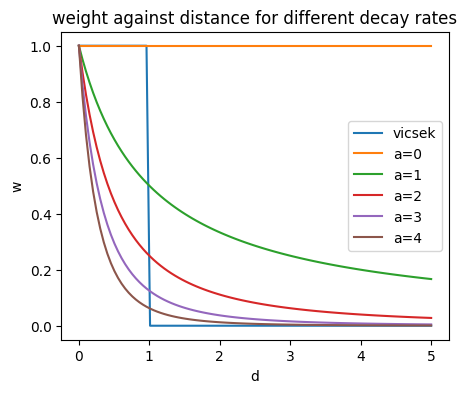

In [ ]:
r_d = 1
d = np.linspace(0,5,num=100)
wv = np.where(d < r_d, 1, 0)
w0 = np.ones(len(d))

plt.figure(figsize=(5,4))
plt.title("weight against distance for different decay rates")
plt.xlabel("d")
plt.ylabel("w")
plt.plot(d, wv, label='vicsek')
plt.plot(d, w0, label='a=0')
#plt.ylim(0,10)


for a in range(1,5):
    w = 1/(1+d)**a
    plt.plot(d, w, label=f'a={a}')

plt.legend()

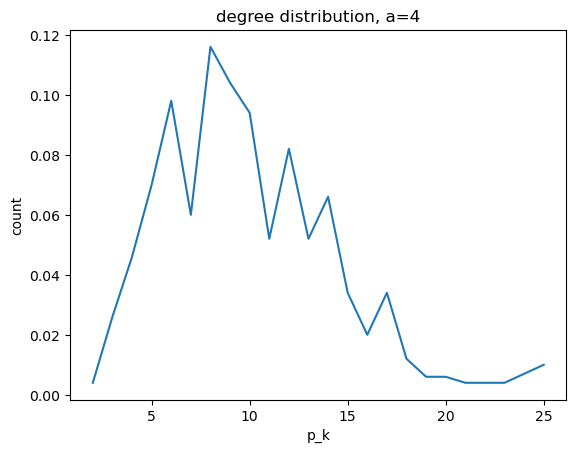

In [ ]:
ks = np.count_nonzero(np.where(D < r_d, 1, 0), axis=0)

plt.figure()
plt.ylabel("count")
plt.xlabel("p_k")
plt.title(f'degree distribution, a={a}')

mean = np.mean(ks)
std = np.std(ks)
unique, counts = np.unique(ks, return_counts=True)

plt.plot(unique, counts/len(ks))
#plt.axvline(mean, color='r')
#plt.axvline(mean+std, color='g')
#plt.axvline(mean-std, color='g')

<ipython-input-23-6cc5646f0a5a>:22: RuntimeWarning: invalid value encountered in divide
  g = n_r/(2*np.pi*r*D_i)/N/bin_size


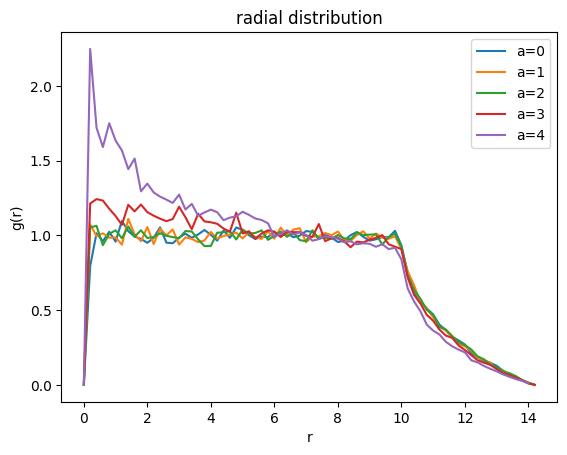

In [ ]:

plt.figure()
plt.ylabel("g(r)")
plt.xlabel("r")
plt.title(f'radial distribution')
N=400
T=600
D_i = 1

for a in [0,1,2,3,4]:
    results = Vicsek_weight(T, N, a, D_i=D_i)
    #x,d,p,D = Vicsek_1d(T, N, a, D_i=1)

    D = results[4]

    ds = D.flatten()
    bin_size =0.2
    ds = np.round(ds/bin_size)
    ds = bin_size*ds
    r, n_r = np.unique(ds, return_counts=True)
    n_r[0] = 0
    r[0] = 0
    g = n_r/(2*np.pi*r*D_i)/N/bin_size
    #g = n_r/(2*D_i)/N/bin_size
    g[0] = 0

    plt.plot(r, g, label=f'a={a}')

plt.legend()

<ipython-input-23-6cc5646f0a5a>:22: RuntimeWarning: invalid value encountered in divide
  g = n_r/(2*np.pi*r*D_i)/N/bin_size


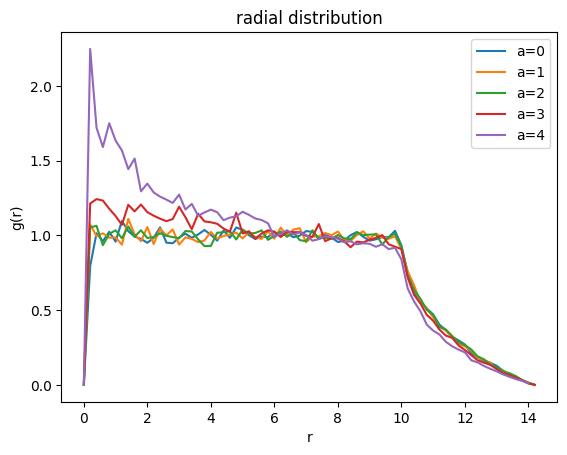

In [ ]:
r_d = 1
N=400
T=600
D_i = 1
d = np.linspace(0,10,num=100)
wv = np.where(d < r_d, 1, 0)
w0 = np.ones(len(d))

plt.figure()
plt.title("sum of weight against distance for different decay rates")
plt.xlabel("d")
plt.ylabel("w")
plt.plot(d, wv, label='vicsek, R=5')
plt.plot(d, w0, label='a=0')
plt.ylim(0,10)


for a in range(1,5):
    w = 1/(1+d)**a
    plt.plot(d, w, label=f'a={a}')

plt.legend()

for a in [0,1,2,3,4]:
    results = Vicsek_weight(T, N, a, D_i=D_i)
    #x,d,p,D = Vicsek_1d(T, N, a, D_i=1)

    D = results[4]

    ds = D.flatten()
    bin_size =0.2
    ds = np.round(ds/bin_size)
    ds = bin_size*ds
    r, n_r = np.unique(ds, return_counts=True)
    n_r[0] = 0
    r[0] = 0
    g = n_r/(2*np.pi*r*D_i)/N/bin_size
    #g = n_r/(2*D_i)/N/bin_size
    g[0] = 0

    plt.plot(r, g, label=f'a={a}')

plt.legend()

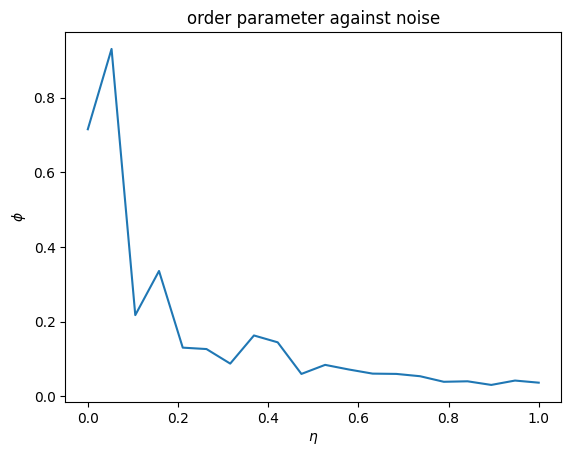

In [ ]:
plt.figure()
plt.ylabel(r"$\phi$")
plt.xlabel(r"$\eta$")
plt.title(f'order parameter against noise')
N=500
T=600
noises = np.linspace(0, 1, 20)

phi_s = np.zeros_like(noises)
for i, noise in enumerate(noises):
    xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=2000, N=500, a=0, R=1, noise=noise, D_i=0.5, t_s=200)
    phi_s[i] = np.mean(phit[-21:-1])

plt.plot(noises, phi_s)

In [ ]:
T=1200
N =500
D_i=1
a=1
L_i = N/D_i
x,d,phit,D = Vicsek_1d(T, N, a, D_i=0.5)

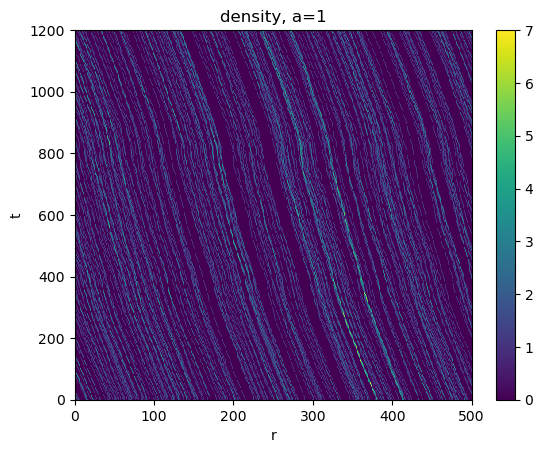

In [ ]:
dr = 1
rt = x


bins = np.arange(0,L_i+dr,dr)
rho_t = np.zeros((T,int(L_i/dr)))
for t in range(T):
    rho_t[t] = np.histogram(rt[t], bins)[0]

plt.figure()
plt.pcolormesh(rho_t)
plt.title(f"density, a={a}")
plt.ylabel("t")
plt.xlabel("r")
plt.colorbar()

In [ ]:
a=0
xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=3000, N=400, a=a, R=1, noise=0.3, D_i=4, t_s=200, var=0.05)

Text(0, 0.5, 'C')

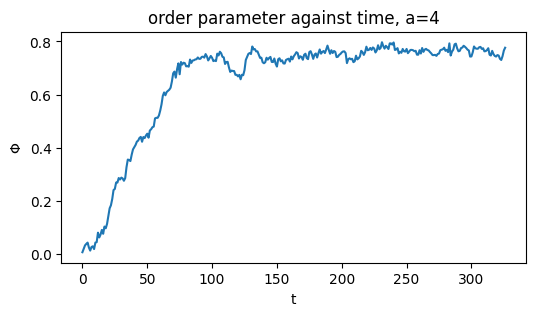

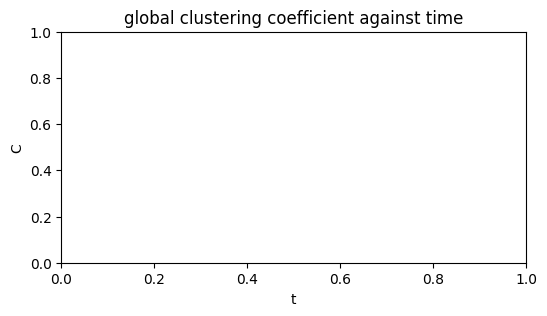

In [ ]:
plt.figure(figsize=(6,3))
plt.title(f"order parameter against time, a={a}")
plt.xlabel("t")
plt.ylabel(r"$\Phi$")
plt.plot(np.arange(T), phit)

plt.figure(figsize=(6,3))
plt.title("global clustering coefficient against time")
plt.xlabel("t")
plt.ylabel("C")
#plt.plot(np.arange(T), Ct)

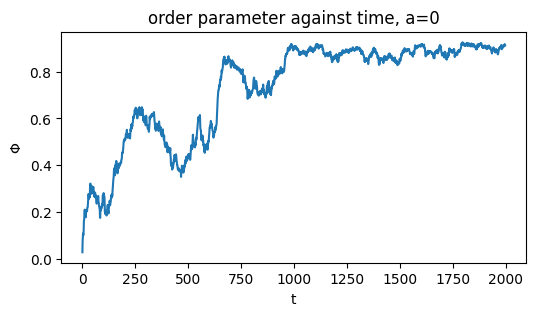

In [ ]:
plt.figure(figsize=(6,3))
plt.title(f"order parameter against time, a={a}")
plt.xlabel("t")
plt.ylabel(r"$\Phi$")
plt.plot(np.arange(T), phit)

SVM
a = 0
a = 1
a = 2
a = 3
a = 4
Time taken: 2580.831853866577


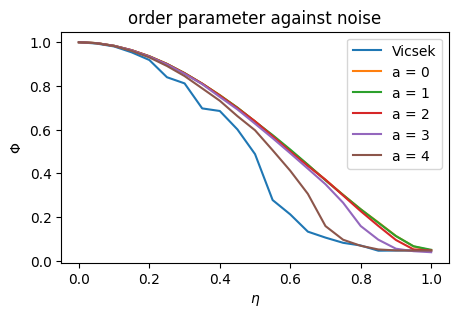

In [ ]:
runs = 21
noises = np.linspace(0,1,runs)

start = time.time()

plt.figure(figsize=(5,3))
plt.title("order parameter against noise")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\Phi$")

a=0
phi_s = np.zeros(runs)
for i,n in enumerate(noises):
    xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=5000, N=400, a=a, R=1, noise=n, D_i=4, s=0.03, t_s=500, var=0.05)
    phi_s[i] = np.mean(phit[-100:-1])
plt.plot(noises, phi_s, label=f'Vicsek')

print('SVM')
for a in [0,1,2,3,4]:
    for i,n in enumerate(noises):
        xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=3000, N=400, a=a, R=-1, noise=n, D_i=4, t_s=300, var=0.05)
        phi_s[i] = np.mean(phit[-100:-1])
    plt.plot(noises, phi_s, label=f'a = {a}')
    print(f'a = {a}')

print("Time taken: "+str(time.time()-start))

plt.legend(loc=1)

SVM
N = 100
N = 200
N = 400
N = 600
Time taken: 3235.097801208496


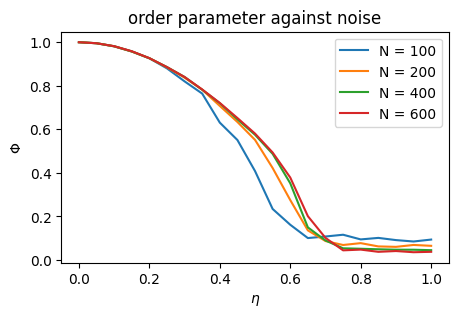

In [ ]:
runs = 21
noises = np.linspace(0,1,runs)

start = time.time()

plt.figure(figsize=(5,3))
plt.title("order parameter against noise")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\Phi$")
phi_s = np.zeros(runs)
a=3
print('SVM')
for N in [100, 200, 400, 600] :
    for i,n in enumerate(noises):
        xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=5000, N=N, a=a, R=-1, noise=n, D_i=1, t_s=300, var=0.05)
        phi_s[i] = np.mean(phit[-100:-1])
    plt.plot(noises, phi_s, label=f'N = {N}')
    print(f'N = {N}')

print("Time taken: "+str(time.time()-start))

plt.legend(loc=1)

In [ ]:
df = pd.DataFrame (phi_s)
#filepath = 'SVM_r3.xlsx'
filepath = 'W_a1.xlsx'
df.to_excel(filepath, index=False)

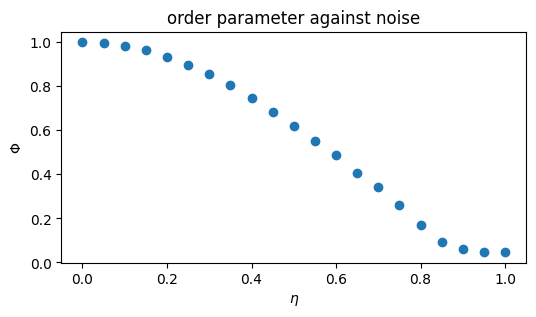

In [ ]:
plt.figure(figsize=(6,3))
plt.title("order parameter against noise")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\Phi$")
plt.scatter(noises, phi_s, label=f'Vicsek')
#plt.xlim(0,1)
#plt.ylim(0,1)

NameError: ignored

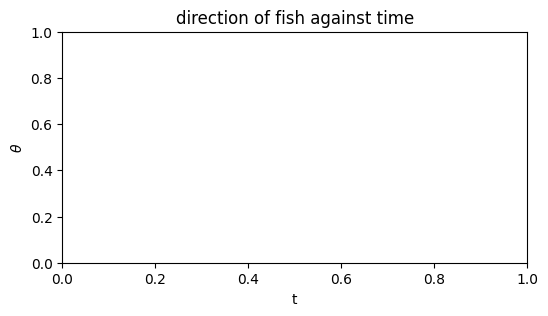

In [ ]:
plt.figure(figsize=(6,3))
plt.title("direction of fish against time")
plt.xlabel("t")
plt.ylabel(r"$\theta$")

for i in range(N):
    di = dirt[:,i]
    plt.plot(np.arange(T), di)




plt.figure(figsize=(6,3))
plt.title("speed of fish against time")
plt.xlabel("t")
plt.ylabel("s")

for i in range(N):
    si = st[:,i]
    plt.plot(np.arange(T), si)

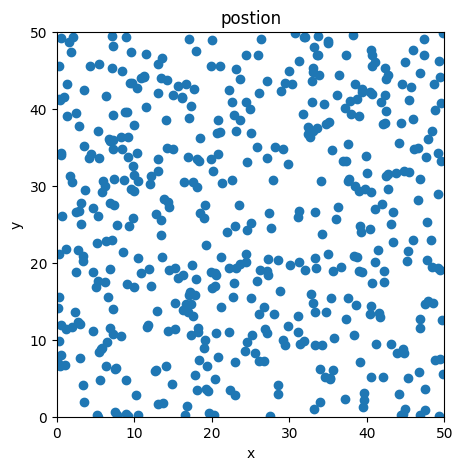

Time taken: 93.53934812545776


In [ ]:
#animation
fig_size = L_i
fig,ax = plt.subplots(figsize=(5, 5))
plt.title("postion")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(0,fig_size)
plt.ylim(0,fig_size)
graph = plt.quiver([], [], [], [])



def animate(i, x, y, rx, ry):
    data = np.column_stack((x[i],y[i],rx[i],ry[i]))
    graph.set_offsets(data)
    return graph,
start = time.time()

ani = FuncAnimation(fig, animate, frames=T, repeat=True, interval=20
                    , fargs=(xt, yt, np.cos(dirt), np.sin(dirt)), blit = True)
plt.show()
ani.save('Vicsek.mp4')
print("Time taken: "+str(time.time()-start))

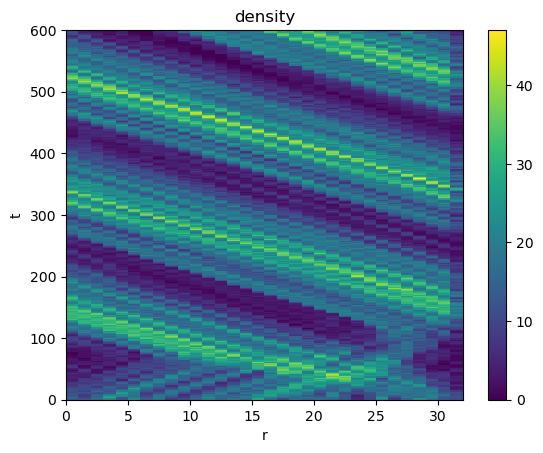

In [ ]:
dim = 1

if dim == 0:
    rt = xt/dr
elif dim == 1:
    rt = yt/dr

bins = np.arange(0,L_i+dr,dr)
rho_t = np.zeros((T,int(L_i/dr)+1))
for t in range(T):
    rho_t[t] = np.histogram(rt[t], bins)[0]

plt.figure()
plt.pcolormesh(rho_t)
plt.title("density")
plt.ylabel("t")
plt.xlabel("r")
plt.colorbar()



In [ ]:
np.shape(bins)

(45,)

(0.0, 0.5)

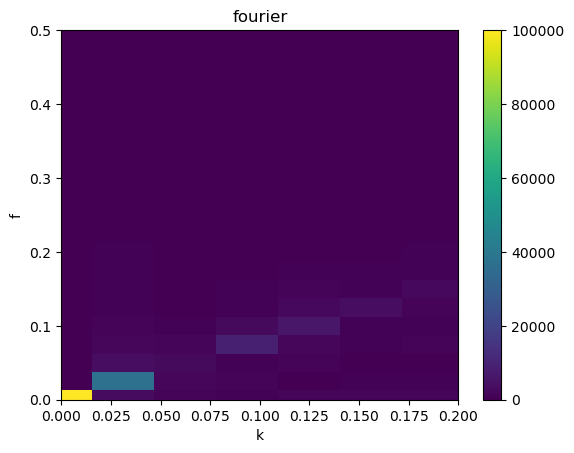

In [ ]:
t_used = 200
fft_rt = np.fft.ifftshift(rho_t[-t_used-1:-1])
fft_rt = np.fft.fft2(fft_rt)
fft_rt = np.fft.fftshift(fft_rt)
ks = np.fft.fftfreq(int(L_i/dr)+1, dr)
ks = np.fft.fftshift(ks)
fs = np.fft.fftfreq(t_used, dt)
fs = np.fft.fftshift(fs)

plt.figure()
plt.pcolormesh(ks, fs, np.abs(fft_rt))
plt.colorbar()
plt.title("fourier")
plt.ylabel("f")
plt.xlabel("k")
plt.xlim([0, 0.2])
plt.ylim([0, 0.5])

In [ ]:
a=0
n=0.3
xt, yt, dirt, phit, D_avg, T = Vicsek_weight(T=5000, N=400, a=a, R=-1, noise=n, D_i=4, s=0.03, t_s=500, var=0.05)

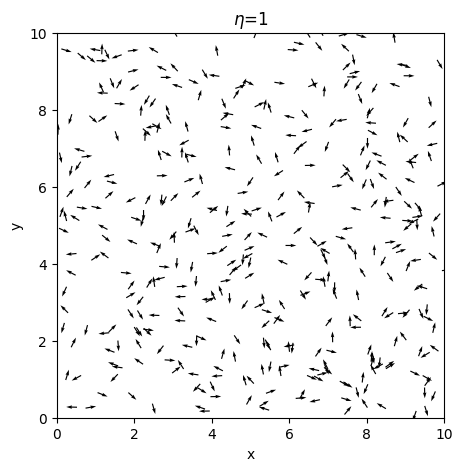

In [ ]:
T, N = np.shape(xt)
fig_size = np.sqrt(N/4)
t = -1
plt.figure(figsize=(5, 5))
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(0,fig_size)
plt.ylim(0,fig_size)
#plt.title(f't = {t}')
plt.title(fr'$\eta$={n}')
#plt.quiver(xt[t], yt[t], np.cos(dirt[t]), np.sin(dirt[t]))



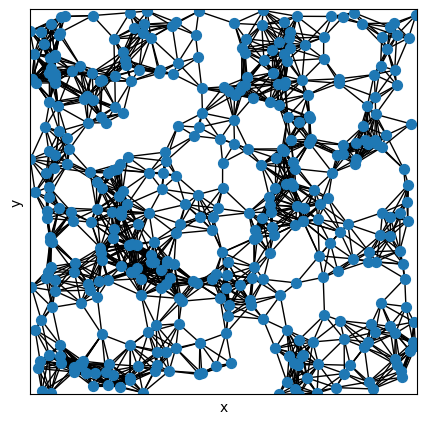

In [ ]:
T, N = np.shape(xt)
R = 1
a = 0
fig_size = np.sqrt(N/4)
t = -1

plt.figure(figsize=(5, 5))
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(0,fig_size)
plt.ylim(0,fig_size)

D = get_dist(xt[t], yt[t], N, fig_size, periodic=False)
W = get_adj(D, R, a)

G = nx.from_numpy_array(W)
G.remove_edges_from(nx.selfloop_edges(G))
pos = {n: (xt[t,n], yt[t,n]) for n in G.nodes()}
nx.draw_networkx(G, pos, with_labels=False, node_size=50)

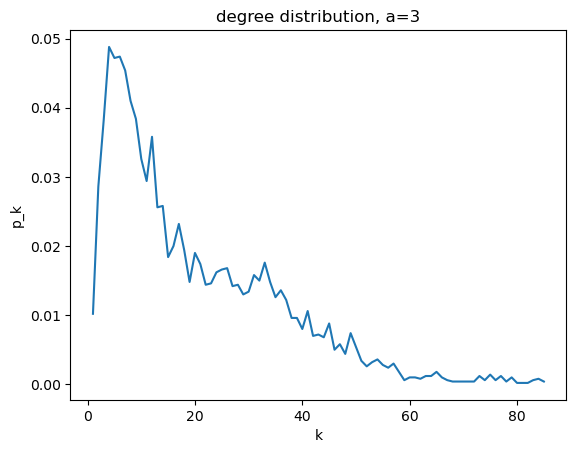

In [ ]:
plt.figure()
plt.ylabel("p_k")
plt.xlabel("k")
plt.title(f'degree distribution, a={a}')

unique, counts = np.unique(ks, return_counts=True)

plt.plot(unique, counts/np.size(ks))

IndexError: list index out of range

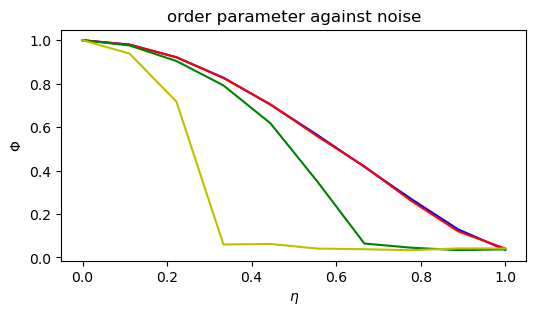

In [ ]:
runs = 10
noises = np.linspace(0,1,runs)

T = 1500 #total time
dt = 0.2 #time interval
N = 500
D = 0.1 #initial density
L_i = np.sqrt(N/D) #length of initial area

R = -1 #detection range
f = 1/dt #tendency to follow
a =3 #order of decay of link
s = 1 #speed
noise = 0.3

start = time.time()

plt.figure(figsize=(6,3))
plt.title("order parameter against noise")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\Phi$")

phi_s = np.zeros(runs)
plot = 0
for a in [0,1,2,3,4]:
#for f in [1/dt,1/dt/5,1/dt/10]:
    for i in range(runs):
        noise = noises[i]

        ns = np.arange(N)
        xs = np.random.rand(N)*L_i
        ys = np.random.rand(N)*L_i
        dirs = (np.random.rand(N)-0.5)*2*np.pi

        phit = np.zeros(T)

        for t in range(T):

            #expand x, y
            xx = np.tile(xs, (N, 1))
            yy = np.tile(ys, (N, 1))



            #update x, y
            xs = xs+s*np.cos(dirs)*dt
            ys = ys+s*np.sin(dirs)*dt

            #periodic
            periodic = True
            if periodic:
                xs = np.mod(xs, R_b)
                ys = np.mod(ys, R_b)

            #update direction
            if periodic:
                dx = np.abs(xx-xx.T)
                dx = np.where(dx < R_b/2, dx, R_b-dx)
                dy = np.abs(yy-yy.T)
                dy = np.where(dy < R_b/2, dy, R_b-dy)
                D = np.sqrt(dx**2+dy**2)
            else:
                D = np.sqrt((xx-xx.T)**2+(yy-yy.T)**2) #distance between nodes
            W = 1/(1+D) #weight between nodes
            #Cut off out of range
            if R != -1: #R=-1 for infinite range
                W = np.where(W > 1/(1+R), W, 0)
            W = np.where(W != 0, W**a, 0)
            Dir = np.tile(dirs, (N, 1))
            #wdir = np.average(Dir, weights=W, axis= 0) #weighted average direction other nodes
            wdir = np.sum(W*Dir, axis=1)/np.sum(W, axis=1)
            #dirs = (dirs*(1-f)+wdir*f)
            #dirs = dirs+(np.random.rand(N)-0.5)*0.01
            #dirs = dirs % (2*np.pi)

            #boundary
            r = np.sqrt(xs**2+ys**2)


            #update v
            #v = v_i+at
            vx = s*np.cos(dirs)
            vy = s*np.sin(dirs)
            #look at other nodes
            Vx = np.tile(vx, (N, 1))
            wvx = np.sum(W*Vx, axis=1)/np.sum(W, axis=1)
            #vx = (vx*(1-f)+wvx*f)
            Vy = np.tile(vy, (N, 1))
            wvy = np.sum(W*Vy, axis=1)/np.sum(W, axis=1)
            #vy = (vy*(1-f)+wvy*f)
            #boundary
            #vx = vx+F_b*np.cos(F_d)*dt
            #vy = vy+F_b*np.sin(F_d)*dt




            #combine vx, vy
            dirs = dirs+dt*f*(np.arctan2(wvy,wvx)-dirs)
            dirs = dirs + noise*2*np.pi*(np.random.rand(N)-0.5) #noise
            #s = np.sqrt(vx**2+vy**2)
            #s = s *(1+noise*(np.random.rand()-0.5)) #noise
            #s = s+(s_0-s)*feedback #negative feedback

            #order parameter
            phi = np.sqrt(np.sum(vx)**2+np.sum(vy)**2)/N/s_0
            phit[t] = phi

        phi_s[i] = np.mean(phit[-21:-1])

    plt.plot(noises, phi_s, label=f'a = {a}')
    plot+=1


print("Time taken: "+str(time.time()-start))

plt.legend(loc=1)


Time taken: 35.233898401260376


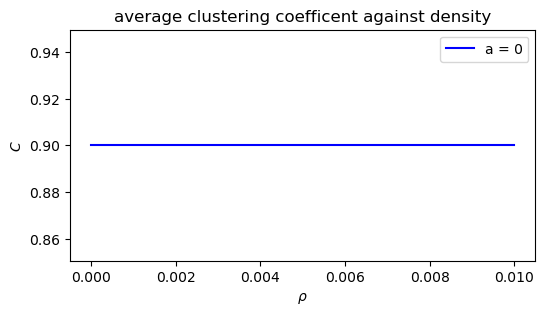

In [ ]:
runs = 10
noise = 0.3
Ds = np.linspace(1e-6,1e-2,runs)

R = 5 #detection range
f_0 = 1/dt #tendency to follow
#a = 0 #order of decay of link

N = 100
T = 250 #time for each run

start = time.time()

plt.figure(figsize=(6,3))
plt.title("average clustering coefficent against density")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$C$")


s = np.ones(N)*s_0
f = np.ones(N)*f_0

C_s = np.zeros(runs)
plot = 0
#for a in [0,1,2]:
for a in [0]:
    for i in range(runs):
        D = Ds[i]
        L_i = np.sqrt(N/D) #length of initial area

        ns = np.arange(N)
        xs = np.random.rand(N)*L_i
        ys = np.random.rand(N)*L_i
        dirs = (np.random.rand(N)-0.5)*2*np.pi

        Ct = np.zeros(T)

        for t in range(T):

                #store data
                xt[t] = xs
                yt[t] = ys
                dirt[t] = dirs
                st[t] = s

                #expand x, y
                xx = np.tile(xs, (N, 1))
                yy = np.tile(ys, (N, 1))

                #update x, y
                xs = xs+s*np.cos(dirs)*dt
                ys = ys+s*np.sin(dirs)*dt

                #periodic
                periodic = True
                if periodic:
                    xs = np.mod(xs, R_b)
                    ys = np.mod(ys, R_b)

                #update direction
                if periodic:
                    dx = np.abs(xx-xx.T)
                    dx = np.where(dx < R_b/2, dx, R_b-dx)
                    dy = np.abs(yy-yy.T)
                    dy = np.where(dy < R_b/2, dy, R_b-dy)
                    D = np.sqrt(dx**2+dy**2)
                else:
                    D = np.sqrt((xx-xx.T)**2+(yy-yy.T)**2) #distance between nodes
                W = 1/(1+D) #weight between nodes
                #Cut off out of range
                if R != -1: #R=-1 for infinite range
                    W = np.where(W > 1/(1+R), W, 0)
                W = np.where(W != 0, W**a, 0)
                Dir = np.tile(dirs, (N, 1))
                #wdir = np.average(Dir, weights=W, axis= 0) #weighted average direction other nodes
                wdir = np.sum(W*Dir, axis=1)/np.sum(W, axis=1)
                #dirs = (dirs*(1-f)+wdir*f)
                #dirs = dirs+(np.random.rand(N)-0.5)*0.01
                #dirs = dirs % (2*np.pi)

                #network
                #G = nx.from_numpy_matrix(W)
                #Ct[t] = nx.average_clustering(G)

                #boundary
                r = np.sqrt(xs**2+ys**2)

                #circle with 1/d force

                if boundary_type == 1:
                    F_b = np.where(R_b-r < w_b, k_b*np.abs(1-(R_b-r)/w_b), 0) #force from boundary
                    F_b = np.where(R_b-r > 0, F_b, 0)
                    F_d = np.arctan2(ys,xs) #direction of force
                    F_d = np.where(R_b > r, F_d, F_d+np.pi)

                #circle with 1/d^2 force
                if boundary_type == 2:
                    F_b = np.where(R_b-r < w_b, k_b*np.abs(1-(R_b-r)/w_b)**2, 0) #force from boundary
                    F_b = np.where(R_b-r > 0, F_b, 0)
                    F_d = np.arctan2(ys,xs) #direction of force
                    F_d = np.where(R_b > r, F_d, F_d+np.pi)

                #update v
                #v = v_i+at
                vx = s*np.cos(dirs)
                vy = s*np.sin(dirs)
                #look at other nodes
                Vx = np.tile(vx, (N, 1))
                wvx = np.sum(W*Vx, axis=1)/np.sum(W, axis=1)
                #vx = (vx*(1-f)+wvx*f)
                Vy = np.tile(vy, (N, 1))
                wvy = np.sum(W*Vy, axis=1)/np.sum(W, axis=1)
                #vy = (vy*(1-f)+wvy*f)
                #boundary
                #vx = vx+F_b*np.cos(F_d)*dt
                #vy = vy+F_b*np.sin(F_d)*dt




                #combine vx, vy
                dirs = dirs+dt*f*(np.arctan2(wvy,wvx)-dirs)
                dirs = dirs + noise*2*np.pi*(np.random.rand(N)-0.5) #noise
                #s = np.sqrt(vx**2+vy**2)
                #s = s *(1+noise*(np.random.rand()-0.5)) #noise
                #s = s+(s_0-s)*feedback #negative feedback

                #order parameter
                #phi = np.sqrt(np.sum(vx)**2+np.sum(vy)**2)/N/s_0
                #phit[t] = phi

        #C_s[i] = np.mean(Ct[-21:-1])

    plt.plot(Ds, C_s, c=['b','r','g','y'][plot], label=f'a = {a}')
    plot+=1


print("Time taken: "+str(time.time()-start))

plt.legend(loc=1)


In [ ]:
def interweave(a, b):
    N = a.shape[1]+ b.shape[1]
    M = a.shape[0]
    out_dtype = np.result_type(a.dtype, b.dtype)
    out = np.empty((M,N),dtype=out_dtype)
    for i in range(a.shape[1]):
        out[:,2*i] = a[:,i]
        out[:,2*i+1] = b[:,i]
    return out

def get_features(D, num_probes):
    probes = np.random.choice(N,num_probes)

    dr = np.zeros((N,num_probes))
    for i,n in enumerate(probes):
        dr[:,i] = np.sort(D[n]-np.mean(D[n]))

    return dr

def get_features_dir(dirs, num_probes):
    probes = np.random.choice(N,num_probes)

    ddir = np.zeros((N-1,num_probes))
    for i,n in enumerate(probes):
        dir_r = dirs-dirs[n]
        ddir[:,i] = np.sort(dir_r-np.mean(dir_r))[1:]

    return ddir

def get_features_alignment(dirs, D, num_probes):
    probes = np.random.choice(N,num_probes)

    ddir = np.zeros((N-1,num_probes))
    for i,n in enumerate(probes):
        dir_r = dirs-dirs[n]
        theta_d = dict(zip(dir_r, D[n]))
        theta_d = sorted(theta_d.items(), key=lambda x:x[1])
        for j,theta in enumerate(theta_d):
            dir_r[j] = theta[0]
        ddir[:,i] = (dir_r-np.mean(dir_r))[1:]

    return ddir


In [ ]:
T=1000
N=500
num_probes = 500

from sklearn.decomposition import PCA
#reference state
xt, yt, dirt, phit, D_avg = Vicsek_weight(T, N, R=5, noise=1, D_i=0.2)
dirs = np.mean(dirt[-21:-1],axis=0)
#X_0 = get_features(D_avg, num_probes)
X_0 = get_features_dir(dirs, num_probes)
#X_0 = get_features_alignment(dirs, D_avg, num_probes)
W_0 = PCA()
W_0.fit(X_0)

PCA()

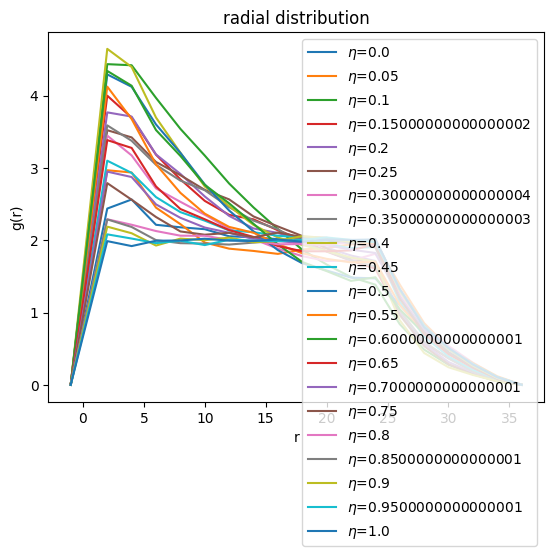

In [ ]:
T=1000
N=500
D_i = 0.2
num_probes = 500
runs = 21
noises = np.linspace(0,1,runs)
phis = np.zeros(runs)
Ps = np.zeros(runs)
g_maxs = np.zeros(runs)

plt.figure()
plt.ylabel("g(r)")
plt.xlabel("r")
plt.title(f'radial distribution')

for i,noise in enumerate(noises):
    xt, yt, dirt, phit, D_avg = Vicsek_weight(T, N, R=5, noise=noise, D_i=D_i)
    phis[i] = np.mean(phit[-21:-1])
    #X = get_features(D_avg, num_probes)
    dirs = np.mean(dirt[-21:-1],axis=0)
    X = get_features_dir(dirs, num_probes)
    #X = get_features_alignment(dirs, D_avg, num_probes)
    X_c = W_0.transform(X)
    W = PCA()
    W.fit(X_c)
    p_i = W.transform(X_c)
    P_1 = np.mean(np.abs(p_i[0]))
    Ps[i] = P_1

    ds = D_avg.flatten()
    bin_size = 2
    ds = np.round(ds/bin_size)
    ds = bin_size*ds
    r, n_r = np.unique(ds, return_counts=True)
    n_r[0] = 0
    r[0] = -1
    g = n_r/(2*np.pi*r*D_i)/N
    #g = n_r/(2*D_i)/N/bin_size
    g[0] = 0
    g_maxs[i] = np.max(g)

    plt.plot(r, g, label=fr'$\eta$={noise}')

plt.legend()


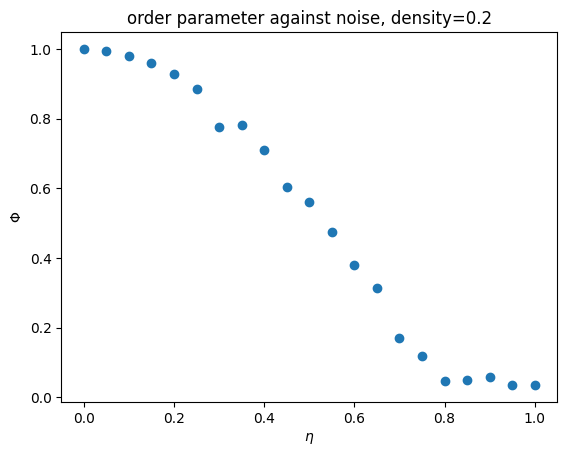

In [ ]:
plt.figure()
plt.title(f"order parameter against noise, density={D_i}")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\Phi$")
plt.scatter(noises,phis)

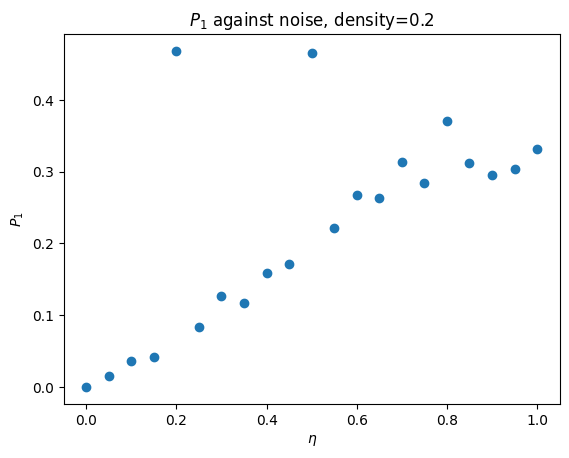

In [ ]:
plt.figure()
plt.title(fr"$P_1$ against noise, density={D_i}")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$P_1$")
plt.scatter(noises,Ps)

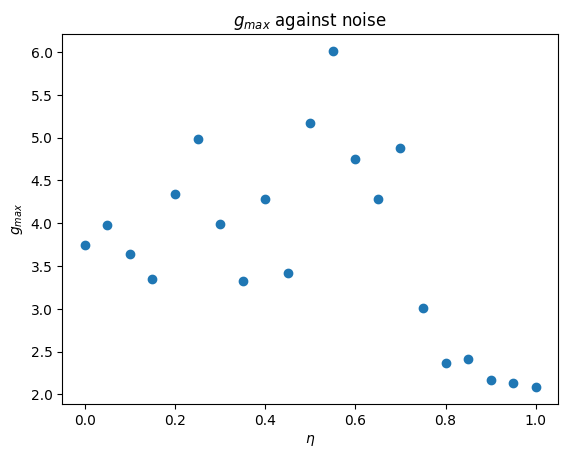

In [ ]:
plt.figure()
plt.title(r"$g_{max}$ against noise")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$g_{max}$")
plt.scatter(noises,g_maxs)

In [ ]:
xt, yt, dirt, phit, D_avg = Vicsek_weight(T, N, R=5, noise=0.3, D_i=0.2)
dirs = np.mean(dirt[-21:-1],axis=0)
get_features_alignment(dirs, D_avg, num_probes)
X_c = W_0.transform(X)
W = PCA()
W.fit(X_c)
p_i = W.transform(X_c)
print("Original shape: {}".format(str(X_c.shape)))
print("Reduced shape: {}".format(str(p_i.shape)))

Original shape: (499, 499)
Reduced shape: (499, 499)


In [ ]:
P_1 = np.mean(np.abs(p_i[0]))
print(P_1)

0.1598019504426358


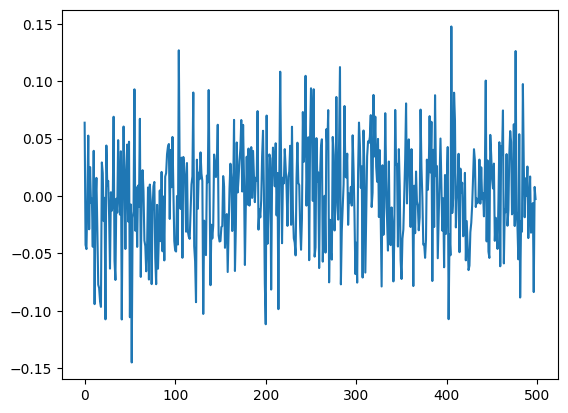

In [ ]:
plt.plot(W.components_[0])

(1e-06, 1)

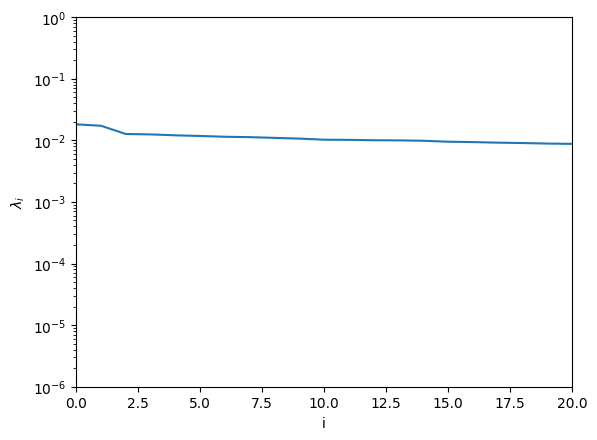

In [ ]:
plt.semilogy(W.explained_variance_ratio_)
plt.ylabel(r'$\lambda_i$')
plt.xlabel('i')
plt.xlim(0, 20)
plt.ylim(0.000001,1)

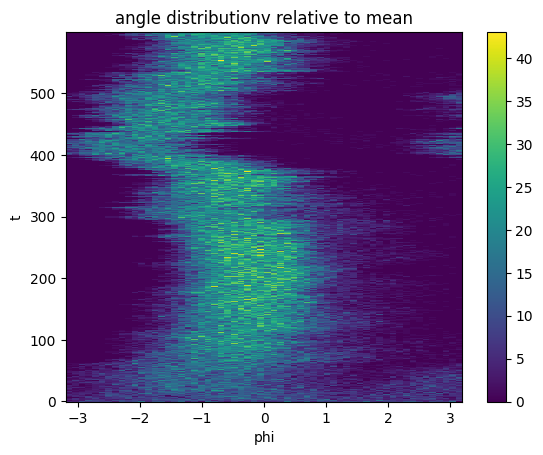

In [ ]:
T = len(dirt)
bins=60

phis = np.linspace(-np.pi,np.pi,bins)
ts = np.arange(T)
rho_t = np.zeros((T,bins))

for t in range(T):
    dd = dirt[t]-np.mean(dirt[t])
    rho_t[t] = np.histogram(dd,bins, range=(-np.pi,np.pi))[0]



plt.figure()
plt.pcolormesh(phis, ts, rho_t)
plt.title(f"angle distributionv relative to mean")
plt.ylabel("t")
plt.xlabel("phi")
plt.colorbar()

In [ ]:
#center of mass
xct = np.mean(xt, axis=0)
yct = np.mean(yt, axis=0)

dxt = xt-xct
dyt = yt-yct

#X_scaled = interweave(dxt, dyt)
X_scaled = rho_t/np.pi

'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dVs)
X_scaled = scaler.transform(dVs)
'''

pca = PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (600, 60)
Reduced shape: (600, 3)


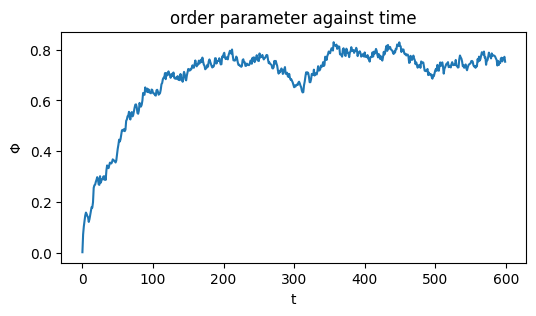

In [ ]:
plt.figure(figsize=(6,3))
plt.title(f"order parameter against time")
plt.xlabel("t")
plt.ylabel(r"$\Phi$")
plt.plot(np.arange(len(phit)), phit)

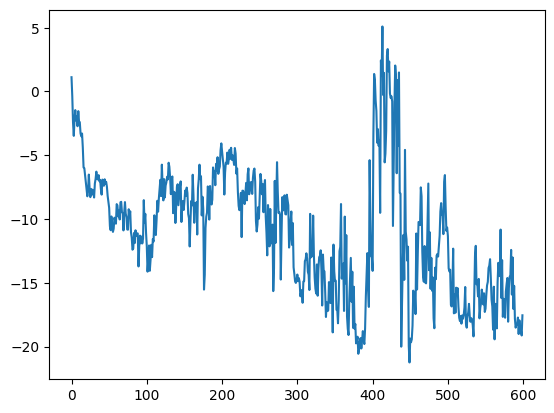

In [ ]:
K = np.matmul(X_scaled, pca.components_[1])
#print(K)
#autocorrelation
C_t = np.zeros(len(K)-1)
for t in range(len(K)-1):
    C_t[t] = np.mean(K[0:len(K)-t]*K[t:len(K)])/np.mean(K**2)

plt.plot(np.arange(len(K)), K)
#plt.plot(np.arange(len(K)-1), C_t)



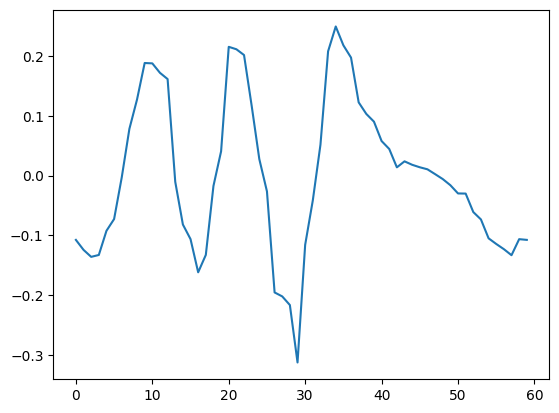

In [ ]:
plt.plot(pca.components_[2])